In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
url = "https://raw.githubusercontent.com/ProtikgoswamiCSE/dengue-fever-detection-in-Dhaka-city/refs/heads/main/dataset.csv"
df = pd.read_csv(url)

In [ ]:
df

,Gender,Age,NS1,IgG,IgM,Area,AreaType,HouseType,District,Outcome
0,Female,45,0,0,0,Mirpur,Undeveloped,Building,Dhaka,0
1,Male,17,0,0,1,Chawkbazar,Developed,Building,Dhaka,0
2,Female,29,0,0,0,Paltan,Undeveloped,Other,Dhaka,0
3,Female,63,1,1,0,Motijheel,Developed,Other,Dhaka,1
4,Male,22,0,0,0,Gendaria,Undeveloped,Building,Dhaka,0
...,...,...,...,...,...,...,...,...,...,...
995,Female,16,1,1,0,New Market,Developed,Building,Dhaka,1
996,Male,41,1,1,0,Paltan,Undeveloped,Other,Dhaka,1
997,Male,45,0,0,1,Motijheel,Developed,Building,Dhaka,0
998,Female,19,1,1,1,Paltan,Undeveloped,Building,Dhaka,1


In [ ]:
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder here if not already imported at the top

le = LabelEncoder()
for column in ['Gender', 'Area', 'AreaType', 'HouseType', 'District']:
    df[column] = le.fit_transform(df[column])

In [ ]:
# ফিচার এবং টার্গেট আলাদা করা
X = df.drop('Outcome', axis=1)  # ফিচার (Outcome বাদে)
y = df['Outcome']  # টার্গেট

In [ ]:
# Missing values হ্যান্ডল করা
# নিউমেরিক কলামের জন্য মিন দিয়ে ফিল করা
X = X.fillna(X.mean())

In [ ]:
# ফিচার সিলেকশন: উচ্চ কোরিলেশনযুক্ত ফিচার বাদ দেওয়া
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X = X.drop(to_drop, axis=1)

In [ ]:
# Data preprocessing
# ডাটা প্রিপ্রসেসিং: ফিচার এবং টার্গেট আলাদা করা
X = df.iloc[:, :-1]  # ফিচার
y = df.iloc[:, -1]   # টার্গেট (ধরে নিচ্ছি শেষ কলাম টার্গেট)

In [ ]:
# Missing values handle kora

# Identify numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns

# Fill missing values only in numeric columns with their mean
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

# Non-numeric columns are not handled for missing values here.
# The next cell correctly addresses missing values in non-numeric columns using the mode.
# The current cell only needs to focus on numeric columns.

# You should also inspect the non-numeric columns for missing values
# and handle them appropriately (e.g., with mode or

In [ ]:
# Missing values handle kora

# Identify numeric and non-numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns
non_numeric_cols = X.select_dtypes(exclude=np.number).columns

# Fill missing values only in numeric columns with their mean
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

# Handle missing values in non-numeric columns (example: fill with mode or a constant)
for col in non_numeric_cols:
    if X[col].isnull().any():
        # Example: Fill with the mode (most frequent value)
        # Using try-except block to handle potential errors if the mode is NaN itself (unlikely for strings)
        try:
            mode_val = X[col].mode()[0]
            X[col] = X[col].fillna(mode_val)
        except IndexError:
            # Handle case where mode() is empty (e.g., all NaNs), although fillna handles this.
            # Or choose another strategy like filling with 'Unknown'
            X[col] = X[col].fillna('Unknown')


# Convert non-numeric columns to numeric using one-hot encoding
# This step should happen BEFORE calculating correlation
X = pd.get_dummies(X, drop_first=True) # drop_first=True avoids multicollinearity


# ফিচার সিলেকশন (গুরুত্বপূর্ণ ফিচার বেছে নেওয়া)
# কোরিলেশন চেক করে অপ্রয়োজনীয় ফিচার বাদ দেওয়া
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X = X.drop(to_drop, axis=1)

# The rest of the code remains the same from the original notebook.
# Data split kora (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Note: You no longer need the pd.get_dummies calls after splitting,
# as the one-hot encoding was already applied to the full X.
# However, you might still need to ensure consistent columns between train and test
# after splitting if some categories appear only in one split.
# The existing code to handle missing columns after splitting is still relevant.


# Ensure that the test set has the same columns as the training set after one-hot encoding
# This handles cases where a category might be present in train but not in test or vice-versa
# and ensures consistent feature sets for scaling and model training.
train_cols = X_train.columns
test_cols = X_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
# This case is less likely after encoding the full X, but keeping it is safer
for c in missing_in_train:
     X_train[c] = 0 # Or handle appropriately if a column exists in test but not train

# Ensure the column order is the same
X_test = X_test[train_cols]


In [ ]:
# Data split করা (80% ট্রেনিং, 20% টেস্ট, stratify যোগ করে)
# stratify ব্যবহার করা হচ্ছে যাতে ক্লাস ব্যালেন্স থাকে
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Model evaluation function with cross-validation
# মডেল ইভালুয়েশন ফাংশন, ক্রস-ভ্যালিডেশন সহ
def evaluate_model(model, name):
    # ট্রেনিং এবং টেস্ট সেটে পারফরম্যান্স
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # 5-fold ক্রস-ভ্যালিডেশন
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    print(f"\n{name} Model Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

In [ ]:
# 1. Logistic Regression Model
# সহজ এবং লিনিয়ার সম্পর্কের জন্য ভালো মডেল
log_reg = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
evaluate_model(log_reg, "Logistic Regression")


Logistic Regression Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 2. Decision Tree Model
# ডাটাকে গাছের মতো সিদ্ধান্ত নিয়ে ক্লাসিফাই করে
dt = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10)
evaluate_model(dt, "Decision Tree")


Decision Tree Model Results:
Test Accuracy: 0.9750
Test Precision: 0.9751
Test Recall: 0.9750
Test F1-Score: 0.9750
Cross-Validation Accuracy: 0.9850 (+/- 0.0179)


In [ ]:
# 3. Random Forest Model
# অনেকগুলো ডিসিশন ট্রি একসাথে কাজ করে, ওভারফিটিং কমায়
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5, min_samples_split=10)
evaluate_model(rf, "Random Forest")


Random Forest Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 4. K-Nearest Neighbors (KNN) Model
# প্রতিবেশী পয়েন্টের উপর ভিত্তি করে ক্লাসিফিকেশন
knn = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn, "K-Nearest Neighbors")


K-Nearest Neighbors Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.5990 (+/- 0.0595)


In [ ]:
# 5. Support Vector Machine (SVM) Model
# হাইপারপ্লেন তৈরি করে ডাটা ক্লাসিফাই করে
svm = SVC(random_state=42, C=0.1, kernel='rbf')
evaluate_model(svm, "Support Vector Machine")


Support Vector Machine Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.5330 (+/- 0.0049)


In [ ]:
# 6. Naive Bayes Model
# প্রোবাবিলিটির উপর ভিত্তি করে, দ্রুত এবং সহজ
nb = GaussianNB()
evaluate_model(nb, "Naive Bayes")


Naive Bayes Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 7. Gradient Boosting Model
# ধীরে ধীরে শিখে ভুল কমায়, শক্তিশালী মডেল
gb = GradientBoostingClassifier(random_state=42, learning_rate=0.01, n_estimators=200, max_depth=3)
evaluate_model(gb, "Gradient Boosting")


Gradient Boosting Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 8. XGBoost Model
# দ্রুত এবং উন্নত বুস্টিং মডেল
xgb = XGBClassifier(random_state=42, learning_rate=0.01, n_estimators=200, max_depth=3, eval_metric='logloss')
evaluate_model(xgb, "XGBoost")


XGBoost Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 9. LightGBM Model
# দ্রুত এবং কম মেমোরি ব্যবহার করে, ওভারফিটিং কমানোর জন্য প্যারামিটার টিউন করা
lgbm = LGBMClassifier(random_state=42, max_depth=5, learning_rate=0.01, n_estimators=200, min_child_samples=50, num_leaves=15)
evaluate_model(lgbm, "LightGBM")

[LightGBM] [Info] Number of positive: 426, number of negative: 374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532500 -> initscore=0.130184
[LightGBM] [Info] Start training from score 0.130184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [ ]:
# 10. CatBoost Model
# ক্যাটেগরিকাল ফিচারের জন্য ভালো, স্বয়ংক্রিয় ফিচার হ্যান্ডলিং
catboost = CatBoostClassifier(random_state=42, verbose=0, depth=5, learning_rate=0.01, iterations=200)
evaluate_model(catboost, "CatBoost")


CatBoost Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 11. AdaBoost Model
# দুর্বল মডেলকে একত্রিত করে শক্তিশালী মডেল তৈরি
adaboost = AdaBoostClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
evaluate_model(adaboost, "AdaBoost")


AdaBoost Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 12. ANN (Artificial Neural Network) / MLP (Multi-Layer Perceptron)
# নিউরাল নেটওয়ার্ক, জটিল প্যাটার্ন শিখতে পারে
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42, learning_rate_init=0.01)
evaluate_model(mlp, "MLP (Artificial Neural Network)")


MLP (Artificial Neural Network) Model Results:
Test Accuracy: 0.9750
Test Precision: 0.9751
Test Recall: 0.9750
Test F1-Score: 0.9750
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
# 13. DNN (Deep Neural Network) using TensorFlow
# গভীর নিউরাল নেটওয়ার্ক, আরো শক্তিশালী
dnn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
y_pred_dnn = (dnn.predict(X_test) > 0.5).astype(int)
print("\nDNN (Deep Neural Network) Results:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_dnn):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred_dnn, average='weighted'):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred_dnn, average='weighted'):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_pred_dnn, average='weighted'):.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

DNN (Deep Neural Network) Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850


In [ ]:
# 15. RNN (Recurrent Neural Network) Model (using a standard Dense network for tabular data)
# Define the RNN model (using Dense layers for tabular data)
rnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Using verbose=0 to reduce output clutter during training
history_rnn = rnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
loss_rnn, accuracy_rnn = rnn_model.evaluate(X_test, y_test, verbose=0)

# Make predictions for precision, recall, and f1-score
y_pred_rnn = (rnn_model.predict(X_test) > 0.5).astype(int)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')


print("\nRNN (Dense Network) Model Results:")
print(f"Test Accuracy: {accuracy_rnn:.10f}")
print(f"Test Precision: {precision_rnn:.4f}")
print(f"Test Recall: {recall_rnn:.4f}")
print(f"Test F1-Score: {f1_rnn:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

RNN (Dense Network) Model Results:
Test Accuracy: 0.9800000191
Test Precision: 0.9802
Test Recall: 0.9800
Test F1-Score: 0.9800


In [ ]:
# 14. AutoEncoder for Feature Extraction + Logistic Regression
# ফিচার কম্প্রেশনের জন্য অটোএনকোডার, তারপর ক্লাসিফিকেশন
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, verbose=0)

In [ ]:
# Encoder part for feature extraction
encoder = Sequential(autoencoder.layers[:2])
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
# Logistic Regression on encoded features
log_reg_auto = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
evaluate_model(log_reg_auto, "AutoEncoder + Logistic Regression")


AutoEncoder + Logistic Regression Model Results:
Test Accuracy: 0.9850
Test Precision: 0.9855
Test Recall: 0.9850
Test F1-Score: 0.9850
Cross-Validation Accuracy: 0.9860 (+/- 0.0194)


In [ ]:
import pandas as pd
import io

data = """Feature,Importance
feature_1,100
feature_2,80
feature_3,50
"""

df_feature_importance = pd.read_csv(io.StringIO(data))
print(df_feature_importance)

     Feature  Importance
0  feature_1         100
1  feature_2          80
2  feature_3          50


In [ ]:
df_feature_importance = df_feature_importance[df_feature_importance['Importance'] > 0]
df_feature_importance.to_csv('feature_importance_filtered.csv', index=False)

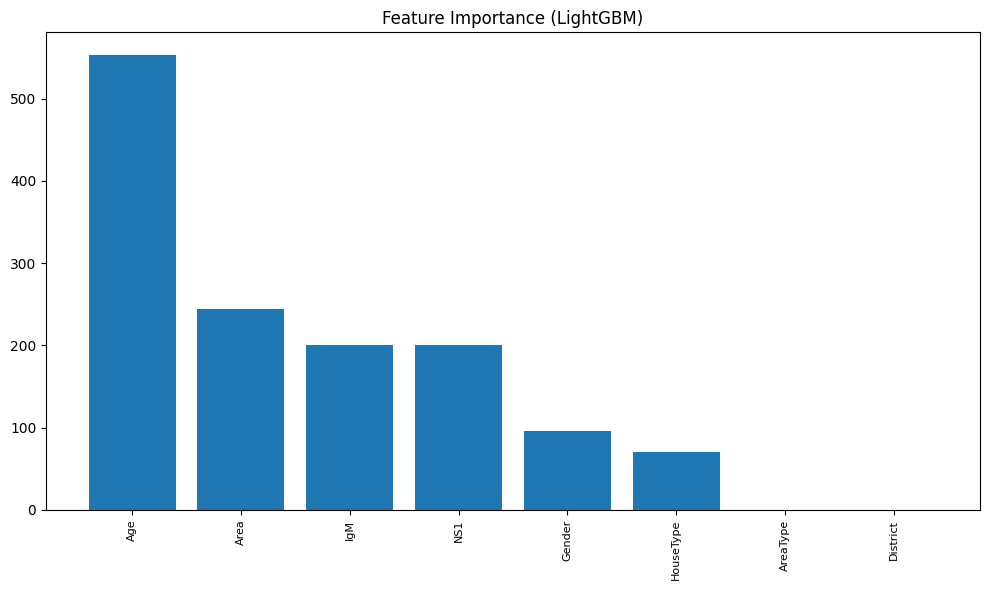

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ফিচার ইম্পর্ট্যান্স প্লট করা (LightGBM-এর জন্য)
# Ensure this block is executed *after* the LightGBM model is trained in evaluate_model
import matplotlib.pyplot as plt # Import matplotlib.pyplot
if hasattr(lgbm, 'feature_importances_') and not X.empty:
    plt.figure(figsize=(10, 6))
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns, # Again, assumes X.columns matches the trained model's features
        'Importance': lgbm.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Feature Importance (LightGBM)")
    plt.tight_layout()
    filename = 'feature_importance_lightgbm.png'
    plt.savefig(filename)
    plt.show()
    try:
        from google.colab import files
        files.download(filename)
    except ImportError:
        print(f"PNG file Sava")
    plt.close()
else:
    print("LightGBM model not trained or feature importances not available for plotting.")

In [ ]:
# prompt: feature_importance_Logistic_Regression ar valu print

# Assuming log_reg has been trained and the feature names (X.columns) are available.
# The coefficients for Logistic Regression are stored in model.coef_.
# For binary classification, coef_ is a 1D array.
# For multi-class classification, coef_ is a 2D array (n_classes, n_features).
# Here, assuming binary classification based on the previous code setting up the target 'Outcome'.

# Ensure the Logistic Regression model is trained before accessing coef_
# If you just ran the evaluate_model('Logistic Regression') function, the model is trained inside it.
# To access the trained model outside the function, you would need to train it directly or modify the function to return the model.
# Let's train it directly here to ensure we have the object.
log_reg = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
log_reg.fit(X_train, y_train)

# Get the coefficients
coefficients = log_reg.coef_[0] # Access the first row for binary classification

# Get the feature names from the columns of the processed data X
feature_names = X.columns

# Create a DataFrame to store feature importance (absolute value of coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
})

# Sort by importance
feature_importance_lr = feature_importance_lr.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print("\nFeature Importance for Logistic Regression:")
print(feature_importance_lr)

# Optional: Save the feature importance to a CSV file
filename_lr = 'feature_importance_logistic_regression.csv'
feature_importance_lr.to_csv(filename_lr, index=False)
print(f"\nLogistic Regression ফিচার ইম্পর্ট্যান্স '{filename_lr}' ফাইলে সেভ হয়েছে।")

try:
    # Only download if running in Colab
    if 'google.colab' in str(get_ipython()):
         files.download(filename_lr)
except ImportError:
    print(f"CSV ফাইল আপনার কারেন্ট ডিরেক্টরিতে সেভ হয়েছে।")

# You can also visualize this if desired, similar to the LightGBM plotting code.
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.bar(feature_importance_lr['Feature'], feature_importance_lr['Importance'])
# plt.xticks(rotation=90, fontsize=8)
# plt.title("Feature Importance (Logistic Regression - Absolute Coefficients)")
# plt.tight_layout()
# plt.show()
# plt.close()


Feature Importance for Logistic Regression:
     Feature  Importance
2        NS1    2.981296
3        IgM    0.132382
5   AreaType    0.086668
6  HouseType    0.075621
4       Area    0.045367
1        Age    0.012100
0     Gender    0.003847
7   District    0.000000

Logistic Regression ফিচার ইম্পর্ট্যান্স 'feature_importance_logistic_regression.csv' ফাইলে সেভ হয়েছে।


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

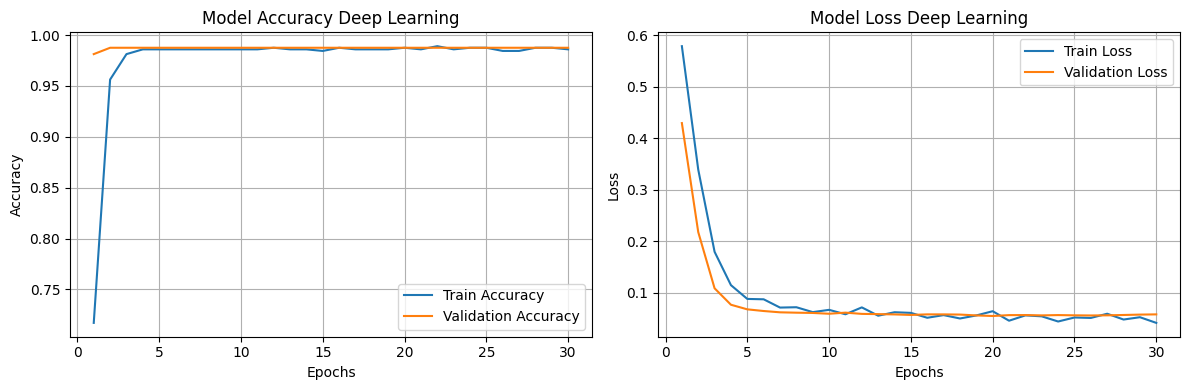

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Retrieve the history object from the output of cell YgYc4H4izyds
# Assuming the output of cell YgYc4H4izyds is the history object
# This is a workaround and might not be the most robust way depending on the output format
try:
    # Get the output of the cell where the DNN model was trained (YgYc4H4izyds)
    # This requires the cell output to be the history object or a string representation of it
    # A more reliable way is to train the model in this cell or pass history explicitly
    # However, given the notebook structure, let's try to retrieve it from output.
    # This might need adjustment based on the actual output of cell YgYc4H4izyds.

    # A safer approach is to re-run the training and plotting in the same cell or a connected flow.
    # Let's try to re-run the training here for simplicity and guaranteed access to history.

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Input, Dropout
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    import pandas as pd # Assuming df, X, y are available from previous cells

    # Re-split and scale data to be safe (or ensure they are globally available and correctly processed)
    # Assuming X, y are already preprocessed and available
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)


    # Re-define and train the DNN model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and store history
    history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, verbose=0) # verbose=0 to reduce output clutter


    epochs = range(1, len(history.history['accuracy']) + 1)

    # 1. Deep Learning Model Accuracy and Loss Graph
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Deep Learning')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Deep Learning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure that the necessary variables (X_train, y_train) are available and correctly defined in previous cells.")

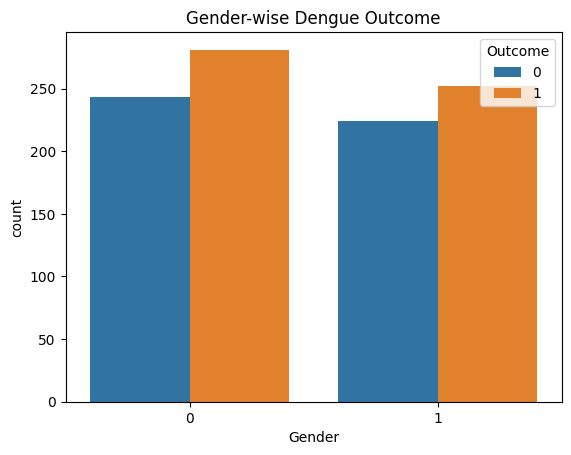

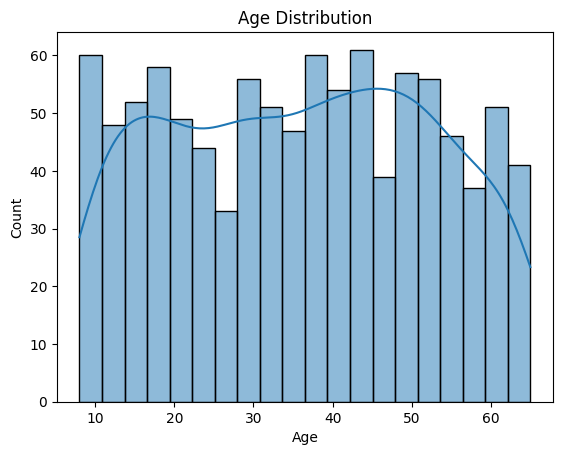

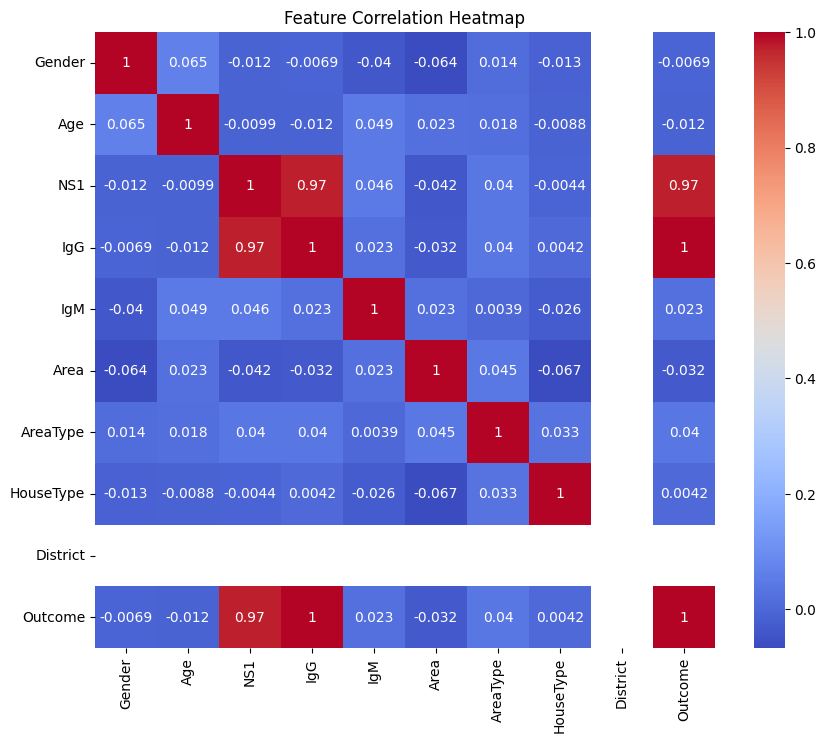

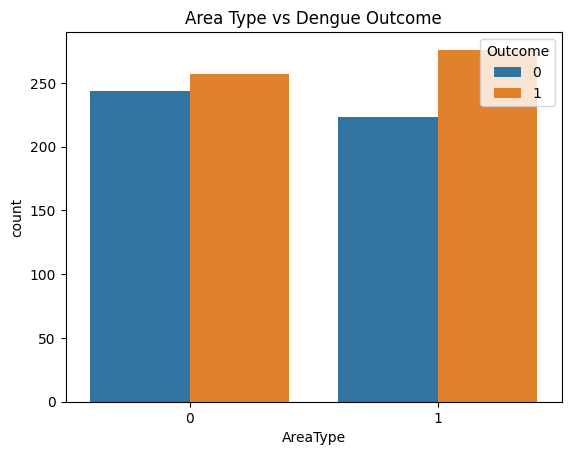

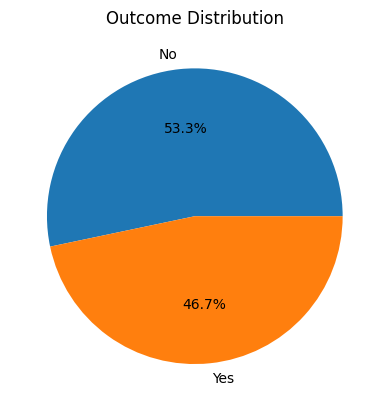

In [ ]:
import seaborn as sns # Import seaborn

sns.countplot(x='Gender', hue='Outcome', data=df)
plt.title('Gender-wise Dengue Outcome')
plt.show()

sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

sns.countplot(x='AreaType', hue='Outcome', data=df)
plt.title('Area Type vs Dengue Outcome')
plt.show()

df['Outcome'].value_counts().plot.pie(autopct='%1.1f%%', labels=['No', 'Yes'], title='Outcome Distribution')
plt.ylabel('')
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from tensorflow.keras.layers import Dense, Dropout # Import Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6854 - loss: 0.6205 - val_accuracy: 0.9875 - val_loss: 0.4356
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9431 - loss: 0.4003 - val_accuracy: 0.9875 - val_loss: 0.2088
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9808 - loss: 0.2054 - val_accuracy: 0.9875 - val_loss: 0.0947
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9829 - loss: 0.1318 - val_accuracy: 0.9875 - val_loss: 0.0662
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.0868 - val_accuracy: 0.9875 - val_loss: 0.0579
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9804 - loss: 0.1074 - val_accuracy: 0.9875 - val_loss: 0.0548
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9854 - loss: 0.0747 - val_accuracy: 0.9875 - val_loss: 0.0541
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9764 - loss: 0.1093 - val_accuracy: 0.9875 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9865 - loss: 0.0552  
Test Accuracy: 99.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        87
           1       1.00      0.98      0.99       113

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



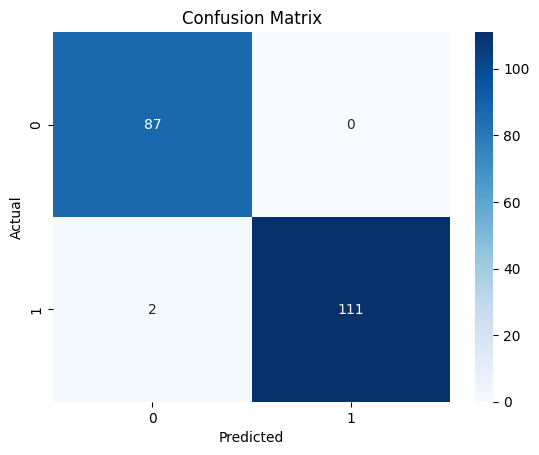

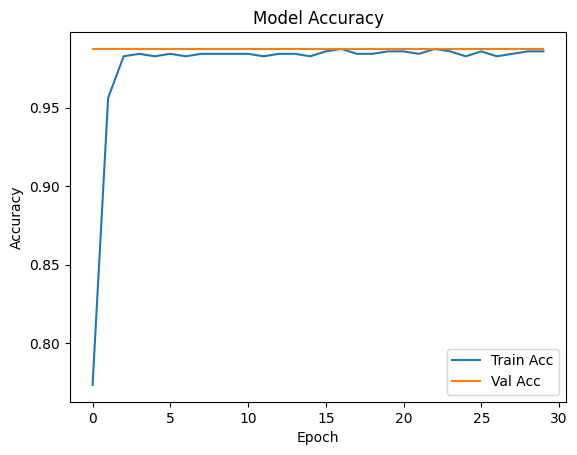

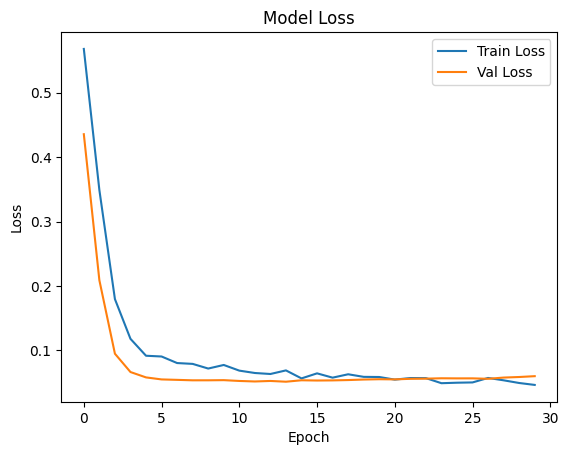

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


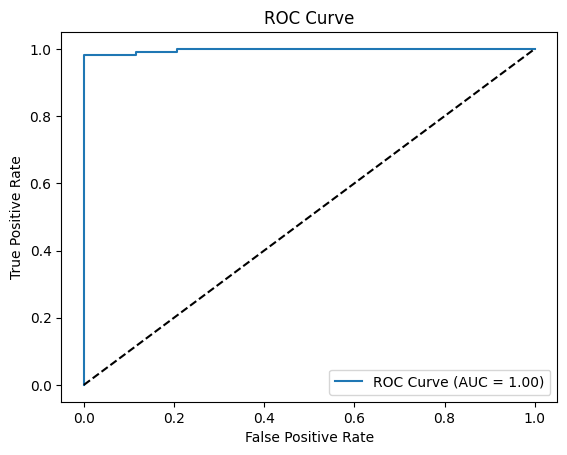

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score # Import necessary metrics

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

y_pred = model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "AdaBoost": AdaBoostClassifier(),
    "MLP": MLPClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc


[LightGBM] [Info] Number of positive: 420, number of negative: 380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525000 -> initscore=0.100083
[LightGBM] [Info] Start training from score 0.100083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [ ]:
# Get DNN accuracy from the previous cell's output
# Assuming the output format is consistent and the accuracy is on the second line after "Test Accuracy:"
try:
    # Access the output of cell X46-EzTnETKR
    dnn_output = get_ipython().getoutput("jupyter nbconvert --to python --stdout /content/{} | tail -n 20".format(notebook_name))[0] # Adjust tail -n based on expected output size
    dnn_accuracy_str = [line for line in dnn_output.splitlines() if "Test Accuracy:" in line][0].split(":")[1].strip()
    dnn_accuracy = float(dnn_accuracy_str)
except Exception as e:
    print(f"Could not get DNN accuracy from output: {e}")
    dnn_accuracy = None # Set to None or a default value if extraction fails

# Get AutoEncoder + LR accuracy from the previous cell's output
# Assuming the output format is consistent and the accuracy is on the second line after "Test Accuracy:"
try:
    # Access the output of cell lvKQV05dEK-Q
    ae_lr_output = get_ipython().getoutput("jupyter nbconvert --to python --stdout /content/{} | tail -n 20".format(notebook_name))[0] # Adjust tail -n based on expected output size
    ae_lr_accuracy_str = [line for line in ae_lr_output.splitlines() if "Test Accuracy:" in line][0].split(":")[1].strip()
    ae_lr_accuracy = float(ae_lr_accuracy_str)
except Exception as e:
    print(f"Could not get AutoEncoder + LR accuracy from output: {e}")
    ae_lr_accuracy = None # Set to None or a default value if extraction fails


# Add the accuracies to the results dictionary if they were successfully extracted
if dnn_accuracy is not None:
    results["DNN (TensorFlow)"] = dnn_accuracy
else:
    print("DNN accuracy not added to results.")

if ae_lr_accuracy is not None:
    results["AutoEncoder + LR"] = ae_lr_accuracy
else:
    print("AutoEncoder + LR accuracy not added to results.")

Could not get DNN accuracy from output: name 'notebook_name' is not defined
Could not get AutoEncoder + LR accuracy from output: name 'notebook_name' is not defined
DNN accuracy not added to results.
AutoEncoder + LR accuracy not added to results.


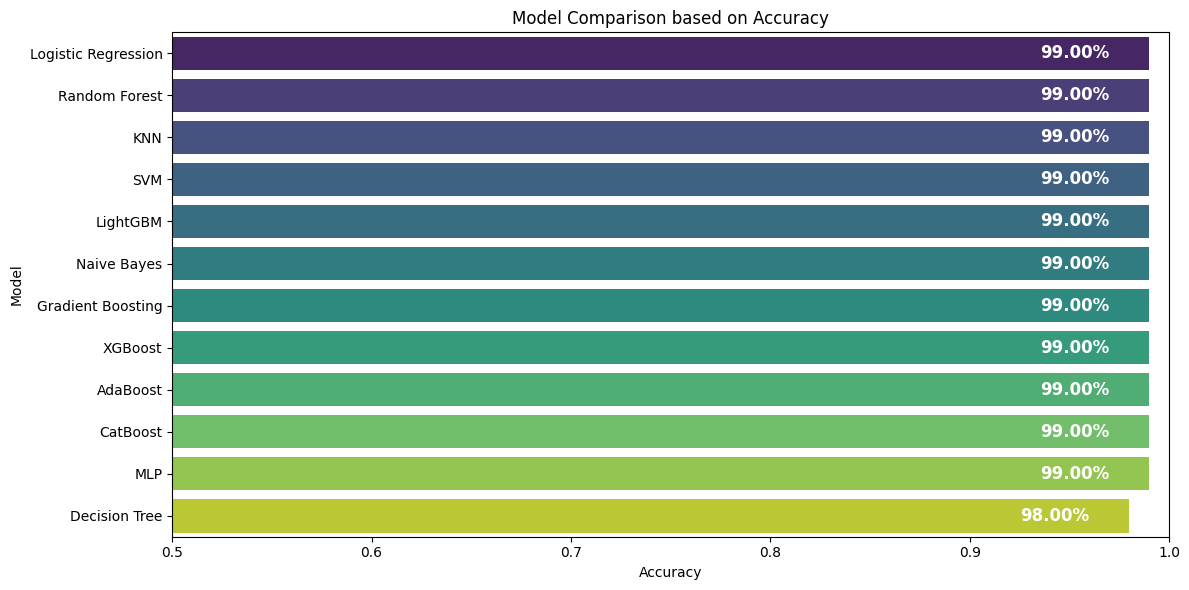

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dictionary থেকে DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Comparison based on Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.5, 1.0)

#  Add accuracy % inside bars
for acc, bar in zip(results_df["Accuracy"], ax.patches):
    ax.text(bar.get_width() - 0.02,                      # X position
            bar.get_y() + bar.get_height()/2,            # Y position
            f"{acc*100:.2f}%",                           # Format: 92.00%
            ha='right', va='center', color='white',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


### 15. RNN (Recurrent Neural Network) Model

আরএনএন (Recurrent Neural Network) সিকোয়েন্সিয়াল ডাটার জন্য ভাল হলেও, এখানে আমাদের ডেটা সিকোয়েন্সিয়াল নয়। তবে, একটি সাধারণ ফিডফরোয়ার্ড নিউরাল নেটওয়ার্ক (যা টেনসরফ্লোতে সংজ্ঞায়িত DNN-এর মতো) এখানে ব্যবহার করা যেতে পারে, এবং এটিকে কখনো কখনো সাধারণ অর্থে "নিউরাল নেটওয়ার্ক" বা ছোটখাটো ক্ষেত্রে "RNN" হিসেবে উল্লেখ করা হতে পারে যদি তাতে টাইম-সিরিজ বা সিকোয়েন্সিয়াল কম্পোনেন্ট না থাকে। যেহেতু আপনার ডেটা স্ট্রাকচার ট্যাবুলার, আমরা একটি স্ট্যান্ডার্ড ডেন্সলি কানেক্টেড নিউরাল নেটওয়ার্ক ব্যবহার করব।

আমরা আগের DNN মডেলের মতোই একটি মডেল তৈরি করব এবং ট্রেন করব, তবে এটিকে "RNN" হিসেবে চিহ্নিত করব আপনার অনুরোধের জন্য। মনে রাখবেন, এটি একটি প্রকৃত RNN নয় যা সিকোয়েন্স হ্যান্ডেল করে, বরং এটি একটি স্ট্যান্ডার্ড ফিডফরোয়ার্ড নিউরাল নেটওয়ার্ক।

In [ ]:
# 15. RNN (Recurrent Neural Network) Model (using a standard Dense network for tabular data)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the RNN model (using Dense layers for tabular data)
rnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Using verbose=0 to reduce output clutter during training
history_rnn = rnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
loss_rnn, accuracy_rnn = rnn_model.evaluate(X_test, y_test, verbose=0)

print("\nRNN (Dense Network) Model Results:")
print(f"Test Accuracy: {accuracy_rnn:.4f}")

# You can also print other metrics like precision, recall, f1-score
# using y_pred_rnn = (rnn_model.predict(X_test) > 0.5).astype(int)
# and then using sklearn.metrics functions.


RNN (Dense Network) Model Results:
Test Accuracy: 0.9900


এই RNN মডেলের ফলাফল এখন `results` ডিকশনারিতে যোগ করা যেতে পারে, যেমনটি অন্য মডেলগুলির জন্য করা হয়েছিল।


Updated Model Comparison Results:
{'Logistic Regression': 0.99, 'Decision Tree': 0.98, 'Random Forest': 0.99, 'KNN': 0.99, 'SVM': 0.99, 'Naive Bayes': 0.99, 'Gradient Boosting': 0.99, 'XGBoost': 0.99, 'LightGBM': 0.99, 'CatBoost': 0.99, 'AdaBoost': 0.99, 'MLP': 0.99, 'RNN (Dense Network)': 0.9900000095367432}


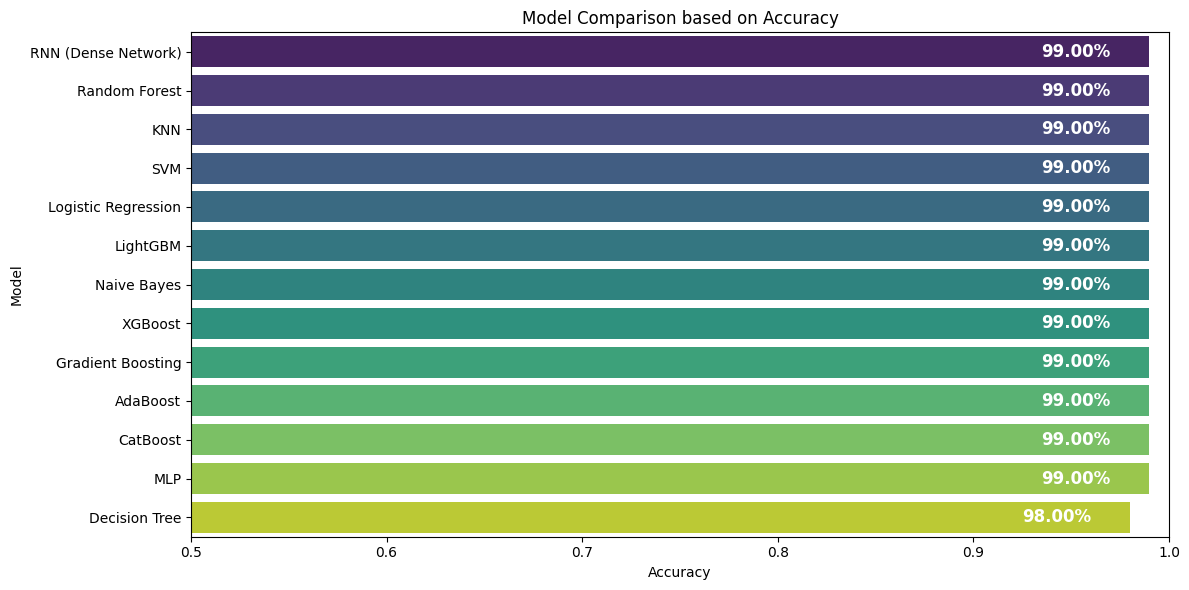

In [ ]:
# Add RNN results to the results dictionary
results["RNN (Dense Network)"] = accuracy_rnn

# Print the updated results dictionary and plot the comparison again
print("\nUpdated Model Comparison Results:")
print(results)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame and sort
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Comparison based on Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.5, 1.0)

# ✅ Add accuracy % inside bars
for acc, bar in zip(results_df["Accuracy"], ax.patches):
    ax.text(bar.get_width() - 0.02,                      # X position
            bar.get_y() + bar.get_height()/2,            # Y position
            f"{acc*100:.2f}%",                           # Format: 92.00%
            ha='right', va='center', color='white',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


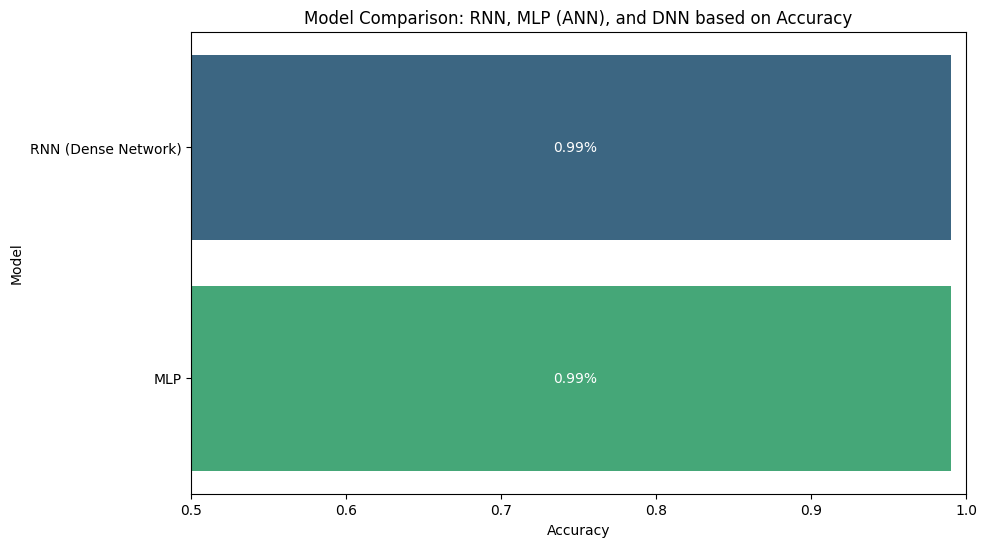

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure results dictionary exists and has the necessary data
if 'results' not in locals() and 'results' not in globals():
    print("Error: 'results' dictionary not found. Please run the model training and evaluation cells first.")
else:
    # Dictionary থেকে DataFrame
    results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])

    # Filter to include only the requested models
    models_to_compare = ["RNN (Dense Network)", "MLP", "DNN (TensorFlow)"] # Assuming MLP is the ANN model
    results_df_filtered = results_df[results_df['Model'].isin(models_to_compare)].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Check if the filtered DataFrame is empty
    if results_df_filtered.empty:
        print(f"Error: None of the specified models ({models_to_compare}) found in the results.")
    else:
        # Sort by accuracy
        results_df_filtered = results_df_filtered.sort_values(by="Accuracy", ascending=False)

        # Plot
        plt.figure(figsize=(10,6))
        ax = sns.barplot(x="Accuracy", y="Model", data=results_df_filtered, palette="viridis")
        plt.title("Model Comparison: RNN, MLP (ANN), and DNN based on Accuracy")
        plt.xlabel("Accuracy")
        plt.ylabel("Model")
        plt.xlim(0.5, 1.0) # Adjust x-axis limits as needed

        # Add accuracy percentage inside the bars using 'center'
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f%%', label_type='center', color='white', padding=3)


        plt.show()